Loading, merging and encoding of data:

In [1]:
import os
import pandas as pd
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

data_dir_1 = '/workspaces/Final-Year-Project/Data/2023/'
file_list = os.listdir(data_dir_1)
sas_files = [file for file in file_list if file.endswith('.XPT') or file.endswith('.xpt')]

first_file_path = os.path.join(data_dir_1, sas_files[0])
merged_df = pd.read_sas(first_file_path, format='xport', encoding='iso-8859-1')

for file_name in sas_files[1:]:
    file_path = os.path.join(data_dir_1, file_name)
    df = pd.read_sas(file_path, format='xport', encoding='iso-8859-1')
    if 'SEQN' not in df.columns:
        continue  
    merged_df = pd.merge(merged_df, df, on='SEQN', how='outer', suffixes=('', f'_{file_name}'))
    del df 

def encode_pad_values(value):
    mapping = {'D': 1, 'M': 2, 'W': 3, 'Y': 4}
    return mapping.get(value, None)  

merged_df['PAD790U'] = merged_df['PAD790U'].apply(encode_pad_values)
merged_df['PAD810U'] = merged_df['PAD810U'].apply(encode_pad_values)

merged_df = merged_df.select_dtypes(include=['float64', 'int64'])

merged_df.to_csv('/workspaces/Final-Year-Project/Cleaned Data/AllMergedData.csv', index=False)

print(merged_df.shape)

(11933, 318)


Creation of diabetes status column

In [2]:
merged_df_cleaned = merged_df[merged_df['RIDSTATR'] == 2]

def categorize_diabetes(row):    
    if (pd.notnull(row['LBXGH']) and row['LBXGH'] >= 5.7) or (pd.notnull(row['LBXGLU']) and row['LBXGLU'] >= 100):
        return 1  # Diabetes / At Risk
    else:
        return 0  # No Diabetes

merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)


merged_df_cleaned = merged_df_cleaned.dropna(subset=['Diabetes Status'])
merged_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8860 entries, 0 to 11932
Columns: 319 entries, SEQN to Diabetes Status
dtypes: float64(318), int64(1)
memory usage: 21.6 MB


/tmp/ipykernel_10690/1569237287.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_cleaned['Diabetes Status'] = merged_df_cleaned.apply(categorize_diabetes, axis=1)


Dropping columns with missing values over threshold

In [3]:
df = merged_df_cleaned

missing_percentage = df.isnull().mean() * 100

columns_to_drop = missing_percentage[missing_percentage > 15].index
df = df.drop(columns=columns_to_drop)

df = df.dropna(axis=0)
#df = df.dropna(thresh=len(df.columns) * 0.9)

df = df[~df.isin ([9,99,999,9999,99999]).any(axis=1)]

df['Diabetes Status'].value_counts()


Diabetes Status
0    2445
1    1816
Name: count, dtype: int64

Balancing the diabetes status class

In [4]:
no_diabetes = df[df['Diabetes Status'] == 0]
diabetes = df[df['Diabetes Status'] == 1]

minority_class_size = min(len(no_diabetes), len(diabetes))

no_diabetes_downsampled = resample(no_diabetes, replace=False, n_samples=minority_class_size, random_state=42)
diabetes_downsampled = resample(diabetes, replace=False, n_samples=minority_class_size, random_state=42)

df_balanced = pd.concat([no_diabetes_downsampled, diabetes_downsampled])

df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

df_balanced.to_csv('/workspaces/Final-Year-Project/Cleaned Data/BalancedData.csv', index=False)

df_balanced['Diabetes Status'].value_counts()  



Diabetes Status
0    1816
1    1816
Name: count, dtype: int64

In [5]:
df_balanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3632 entries, 0 to 3631
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SEQN             3632 non-null   float64
 1   HUQ010           3632 non-null   float64
 2   HUQ030           3632 non-null   float64
 3   HUQ042           3632 non-null   float64
 4   HUQ055           3632 non-null   float64
 5   HUQ090           3632 non-null   float64
 6   INDFMMPC         3632 non-null   float64
 7   INQ300           3632 non-null   float64
 8   SDDSRVYR         3632 non-null   float64
 9   RIDSTATR         3632 non-null   float64
 10  RIAGENDR         3632 non-null   float64
 11  RIDAGEYR         3632 non-null   float64
 12  RIDRETH1         3632 non-null   float64
 13  RIDRETH3         3632 non-null   float64
 14  RIDEXMON         3632 non-null   float64
 15  DMDBORN4         3632 non-null   float64
 16  DMDHHSIZ         3632 non-null   float64
 17  WTINT2YR      

In [6]:

df_balanced.shape

(3632, 45)

Correlation matrix creation

Text(0.5, 1.0, 'Correlation Matrix')

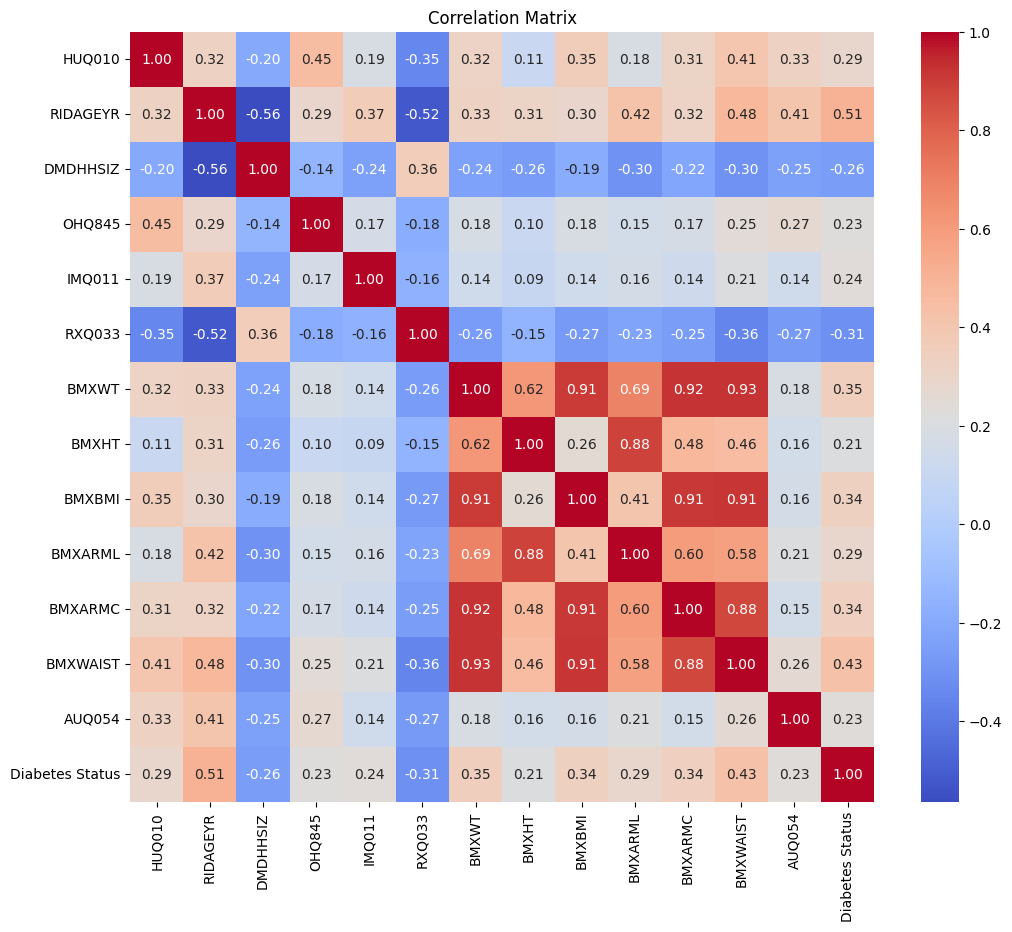

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df_corr = df_balanced.corr()

df_top_filtered = df_corr['Diabetes Status'].abs()[df_corr['Diabetes Status'].abs() > 0.20]

columns_to_keep = df_top_filtered.index
df_filtered = df_balanced[columns_to_keep]

plt.figure(figsize=(12, 10))

sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlation Matrix')

In [8]:
df_filtered.shape

(3632, 14)

Splitting validation data

In [9]:
df_train_test, df_validate = train_test_split(df_filtered, test_size=0.1, random_state=42)

df_filtered.to_csv('/workspaces/Final-Year-Project/Cleaned Data/DataTopCorrelationData.csv', index=False)
df_validate.to_csv('/workspaces/Final-Year-Project/Cleaned Data/ValidationData.csv', index=False)
df_train_test.to_csv('/workspaces/Final-Year-Project/Cleaned Data/TrainTestData.csv', index=False)

print("Final Diabetes Status Distribution:\n", df_train_test['Diabetes Status'].value_counts())
print("Final Dataset Info:\n")
df_train_test.info()

Final Diabetes Status Distribution:
 Diabetes Status
0    1638
1    1630
Name: count, dtype: int64
Final Dataset Info:

<class 'pandas.core.frame.DataFrame'>
Index: 3268 entries, 1352 to 3174
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HUQ010           3268 non-null   float64
 1   RIDAGEYR         3268 non-null   float64
 2   DMDHHSIZ         3268 non-null   float64
 3   OHQ845           3268 non-null   float64
 4   IMQ011           3268 non-null   float64
 5   RXQ033           3268 non-null   float64
 6   BMXWT            3268 non-null   float64
 7   BMXHT            3268 non-null   float64
 8   BMXBMI           3268 non-null   float64
 9   BMXARML          3268 non-null   float64
 10  BMXARMC          3268 non-null   float64
 11  BMXWAIST         3268 non-null   float64
 12  AUQ054           3268 non-null   float64
 13  Diabetes Status  3268 non-null   int64  
dtypes: float64(13), int64(1)
memory us

IMQ011 = Recieved Hepatitis Vaccine

RIDAGEYR = Age

DMDHHSIZ = Total Number Of People In Household

HUQ010 = Self Perceived Health

AUQ054 = General Condtion of Hearing

OHQ845 = Self Rating of Teeth and Gum Health

BMXWT = Weight KG

BMXHT = Height CM

BMXBMI = BMI

BMXARML = Arm Length CM

BMXARMC = Arm Circumfrence CM

BMXWAIST = Waist Circumference CM

RXQ033 = Taken prescription medication in last 30 days 